# **Jigsaw Unintended Bias: Model Performance**

# **Contents**
### 1. Load the data and model 
### 2. Model Performance Analysis
### 3. Conclusion

In [1]:
#import dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Add, Concatenate
from tensorflow.keras.layers import  SpatialDropout1D, Dropout, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model

import random
import datetime
import gc
import pickle
import sys
import os
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# **1. Load the data and model**

In [ ]:
toxicity_feat = ['target_cont','severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
identity_main = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',  'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [ ]:
toxicity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/toxicity_data.csv')
print("Shape:",toxicity_data.shape)
toxicity_data.head()

Shape: (1804874, 7)


,target_cont,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
4,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0


In [ ]:
identity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/identity_data.csv')
for col in identity_data.columns:
    identity_data[col].fillna(0, inplace=True)
    if col=='target_cont':
        identity_data['target'] = identity_data[col].apply(lambda x: 1 if x>=0.5 else 0).astype(int)
    else:
        identity_data[col] = identity_data[col].apply(lambda x: 1 if x>=0.5 else 0).astype(int)
print("Shape:",identity_data.shape)
identity_data.head()

Shape: (1804874, 11)


,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target_cont,target
0,0,0,0,0,0,0,0,0,0,0.000000,0
1,0,0,0,0,0,0,0,0,0,0.000000,0
2,0,0,0,0,0,0,0,0,0,0.000000,0
3,0,0,0,0,0,0,0,0,0,0.000000,0
4,0,0,0,0,0,0,0,0,0,0.893617,1


In [ ]:
train_pre = pd.read_pickle('/content/gdrive/MyDrive/Jigsaw Files/preprocessed_train.pkl')
train_pre = pd.concat([train_pre, identity_data[identity_main]], axis=1)
train_pre.head()

,target,comment_text,preprcsd,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,0,"This is so cool. It's like, 'would you want yo...",cool like would want mother read really great ...,0,0,0,0,0,0,0,0,0
1,0,Thank you!! This would make my life a lot less...,thank would make life lot less anxiety induce ...,0,0,0,0,0,0,0,0,0
2,0,This is such an urgent design problem; kudos t...,urgent design problem kudos take impressive,0,0,0,0,0,0,0,0,0
3,0,Is this something I'll be able to install on m...,something able install site release,0,0,0,0,0,0,0,0,0
4,1,haha you guys are a bunch of losers.,haha guy bunch loser,0,0,0,0,0,0,0,0,0


In [3]:
#code reference - https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/ 
class AttentionWithContext(Layer):
    """
    Basically, hidden state of each timestep is passed through a hidden dense layer of n units, with a softmax layer on top which returns the attention weights for each timestep.
    The context vector is then calculated as the attention weighted sum of timestep hidden states.
    Input shape
        3D tensor with shape: (samples, steps, features).
    Output shape
        2D tensor with shape: (samples, features).
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, units=None,return_weights=False,**kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_weights = return_weights
        self.units = units
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        if self.units!=None:
            num_units = self.units
        else:
            num_units = input_shape[-1]
            
        self.W = self.add_weight(name = 'att_W',
                             shape =  (input_shape[-1], num_units),
                             initializer=self.init,
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint,
                             trainable=True)
        if self.bias:
            self.b = self.add_weight(name = 'att_b',
                                 shape = (num_units,),
                                 initializer='zero',
                                 regularizer=self.b_regularizer,
                                 constraint=self.b_constraint,
                                 trainable=True)
        self.u = self.add_weight(name = 'att_u',
                                 shape = (num_units,1),
                                 initializer=self.init,
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint,
                                 trainable=True)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.matmul(x, self.W) #x(256,).W(256,128) -> uit(128,)

        if self.bias:
            uit += self.b #uit(128,)+b(128,) -> uit(128,)

        uit = tf.keras.activations.tanh(uit) #uit(128,)
        ait = tf.matmul(uit, self.u) #uit(128,).u(128,) -> ait(1,)

        a = tf.keras.activations.exponential(ait) #a(105,1) for all timesteps

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 

        weighted_input = x * a #x(105,256)*a(105,1)
        weighted_sum = K.sum(weighted_input,axis=1) #weighted_sum(256,) : context vector
        if self.return_weights:
            return [weighted_sum, a]
        return weighted_sum

    def compute_output_shape(self, input_shape):
        if self.units!=None:
            return input_shape[0], self.units
        return input_shape[0], input_shape[-1]
    
    def get_config(self):
        config = super(AttentionWithContext, self).get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias' : self.bias,
            'units': self.units,
            'return_weights' : self.return_weights
        })
        return config

In [4]:
def load_model(path, contain_custom_obj=False):
    config = pickle.load(open(path+'.pkl','rb'))
    if contain_custom_obj:
        custom_objects = {"AttentionWithContext": AttentionWithContext}
        with tf.keras.utils.custom_object_scope(custom_objects):
            model = tf.keras.Model.from_config(config['config'])
    else: 
        model = tf.keras.Model().from_config(config['config'])
    model.load_weights(path+'_weights.h5')
    return model

In [11]:
padlen = 105
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl'
tok =  pickle.load(open(tok_path, 'rb'))
model_4_path = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_4'
model_4 = load_model(model_4_path, contain_custom_obj=True)

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/X_train_pad.npy')
y_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/y_train.npy')
embed_mat = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/embed_mat.npy')

In [ ]:
y_train_pred = model_4.predict(X_train, batch_size=2048, verbose=1)
train_pre['Model_4'] = y_train_pred[0]

882/882 [==============================] - 129s 140ms/step


In [ ]:
train_pre['Error'] = abs(train_pre['target'] - train_pre['Model_4'])

# **2. Model Performance Analysis**

## **2.1 PDF and CDF of Model Output**

In [91]:
# train_pre.to_csv('/content/gdrive/MyDrive/df_for_perf.csv', index=False)
train_pre = pd.read_csv('/content/gdrive/MyDrive/df_for_perf.csv')
train_pre.head()

,target,comment_text,preprcsd,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,Model_4,Error
0,0,"This is so cool. It's like, 'would you want yo...",cool like would want mother read really great ...,0,0,0,0,0,0,0,0,0,0.003321,0.003321
1,0,Thank you!! This would make my life a lot less...,thank would make life lot less anxiety induce ...,0,0,0,0,0,0,0,0,0,0.000611,0.000611
2,0,This is such an urgent design problem; kudos t...,urgent design problem kudos take impressive,0,0,0,0,0,0,0,0,0,0.000578,0.000578
3,0,Is this something I'll be able to install on m...,something able install site release,0,0,0,0,0,0,0,0,0,0.001060,0.001060
4,1,haha you guys are a bunch of losers.,haha guy bunch loser,0,0,0,0,0,0,0,0,0,0.990736,0.009264


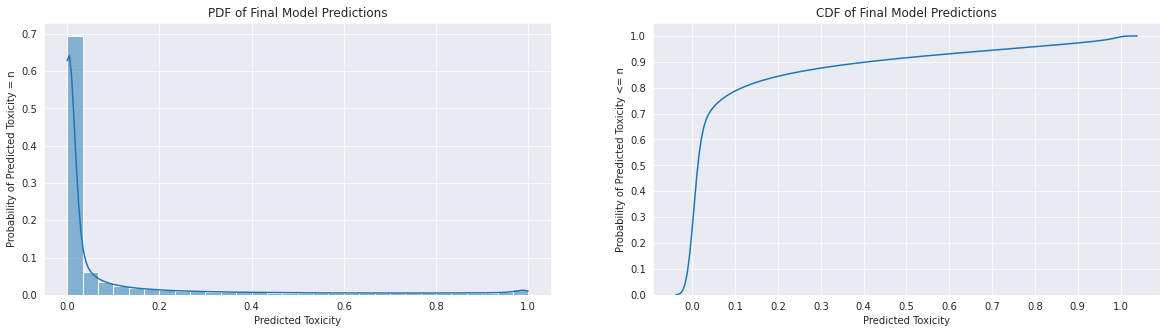

In [94]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data=train_pre, x="Model_4", bins=30, stat = 'proportion', ax=ax[0], kde=True)
ax[0].set(xlabel='Predicted Toxicity', ylabel='Probability of Predicted Toxicity = n', title='PDF of Final Model Predictions')
sns.kdeplot(data=train_pre, x="Model_4", ax=ax[1], cumulative=True)
ax[1].set(xlabel='Predicted Toxicity', ylabel='Probability of Predicted Toxicity <= n', title='CDF of Final Model Predictions')
ax[1].set_xticks(np.arange(0,1.1,0.1))
ax[1].set_yticks(np.arange(0,1.1,0.1))
plt.show()

Observations:
- Most point predictions are near 0 and 1 indicating that the model is quite confident in it's predictions.
- ~80% of predicted probabilities are less than 0.1
- ~5% of the predicted probabilities are higher than 0.7

## **2.2 PDF and CDF of Error**

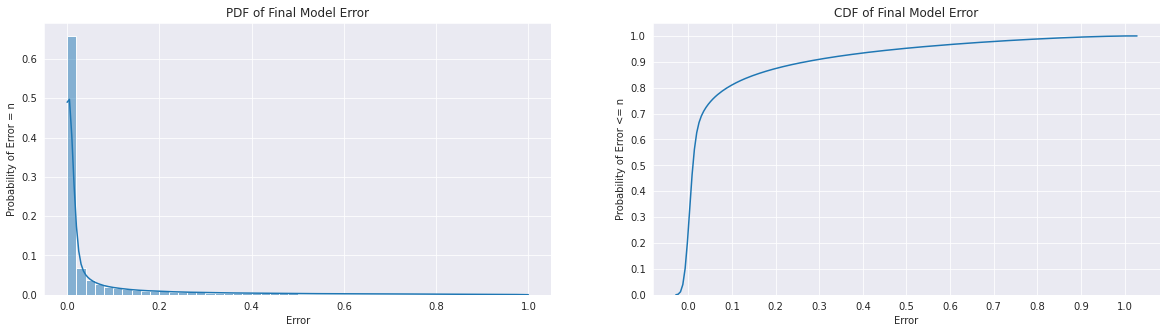

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data=train_pre, x="Error", bins=50, stat = 'proportion', ax=ax[0], kde=True)
ax[0].set(xlabel='Error', ylabel='Probability of Error = n', title='PDF of Final Model Error')
sns.kdeplot(data=train_pre, x="Error", ax=ax[1], cumulative=True)
ax[1].set(xlabel='Error', ylabel='Probability of Error <= n', title='CDF of Final Model Error')
ax[1].set_xticks(np.arange(0,1.1,0.1))
ax[1].set_yticks(np.arange(0,1.1,0.1))
plt.show()

Observations:
- ~80% of point errors <= 0.1 which implies that 80% of times the model is highly confident in its predictions.
- ~5% of point errors >= 0.4 indicating that 5% of the times the model is shows low confidence in its predictions.


## **2.3 Observe Low and High Error Points**

Next step is to observe the low and high error samples separately. 

In [119]:
""" Helper Functions """

def tokenize_text(text, tokenizer, padlen):
    sequence = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequence, maxlen = padlen)
    return padded

def viz_attention(pre_text,  tokenizer, padlen, att_model):
    words = pre_text[0].split(' ')
    total_words = len(words)
    sequence = tokenize_text(pre_text, tokenizer, padlen)

    att_weights = att_model.predict(sequence).reshape(1,105) #att_wieghts.sum()==1
    
    plt.figure(figsize=(20,5)) 
    ax = sns.heatmap(att_weights[:,-total_words:], vmin=0, vmax=1, cmap='YlGnBu', xticklabels = words, yticklabels=[None])
    ax.set(title = 'Attention Weights: Importance given to a word', xlabel='Words')
    return plt.show()

def print_info(df, colname, num_rows, tokenizer, padlen, att_model):
    row_num = list(df.columns).index(colname)
    for i in range(num_rows):
        ids = ", ".join([k for k,v in df.iloc[i,range(3,12)].to_dict().items() if v==1])
        print(f'Comment: {df.iloc[i,1]} \nPreprocessed: {df.iloc[i,2]} \nIdentities: {ids} \nActual: {df.iloc[i,0]} \nPrediction: {df.iloc[i,row_num]}\n')
        viz_attention([df.iloc[i,2]], tokenizer, padlen, att_model)
        print('-'*200+'\n')

In [108]:
padlen = 105
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl'
tok =  pickle.load(open(tok_path, 'rb'))
mod_path = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_4'
mod = load_model(mod_path, contain_custom_obj=True)
att = mod.get_layer('attention_with_context').output[1]
att_mod = Model(inputs=mod.input, outputs=att)

### **2.3.1 Observing Samples where Prediction Errors are Low**

### Class Distribution

In [120]:
#class distribution in samples with high accuracy predictions
train_pre[train_pre['Error']<=0.1]['target'].value_counts(normalize=True)

0    0.9684
1    0.0316
Name: target, dtype: float64

### Toxic Comments

Comment: Coming back after a year of volunteer work in Africa only to hear " they are too ignorant and should die of AIDS" was the sadest moment in my life as a Canadian. It is the moment I knew there are as many ignorant assholes in Canada as the US. Canada is the epicentre of white privilege.... just too arrogant to acknowledge their colonialist attitudes with systemic racist undertones. We just tell ourselves we are the nice ones. I am sorry you and your wife had issues, it happened to me as well. 
Preprocessed: come back year volunteer work africa hear ignorant die aid sadest moment life canadian moment know many ignorant asshole canada us canada epicentre white privilege arrogant acknowledge colonialist attitude systemic racist undertone tell nice one sorry wife issue happen well 
Identities: white 
Actual: 1 
Prediction: 0.94693744

1/1 [==============================] - 0s 108ms/step


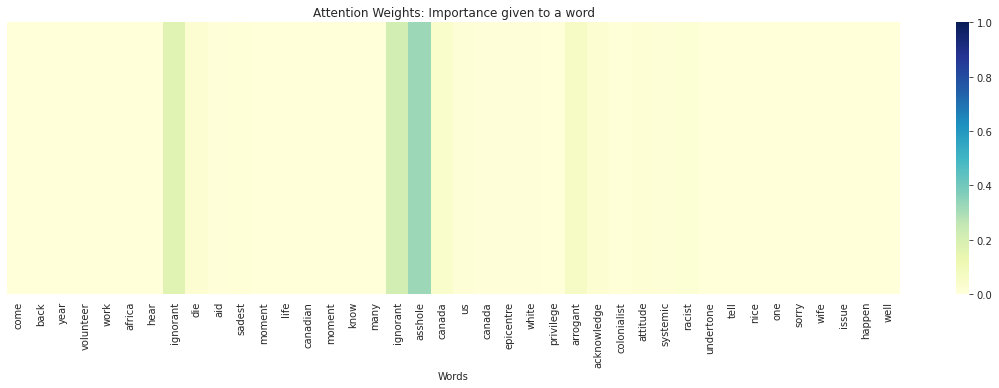

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Yeah, by Muslims committing horrifying acts of mass murder by suicide. I mean, who does that?  Crazy people and Muslim fundamentalists. 
Preprocessed: yeah muslim commit horrify act mass murder suicide mean crazy people muslim fundamentalist 
Identities: muslim 
Actual: 1 
Prediction: 0.9750929

1/1 [==============================] - 0s 50ms/step


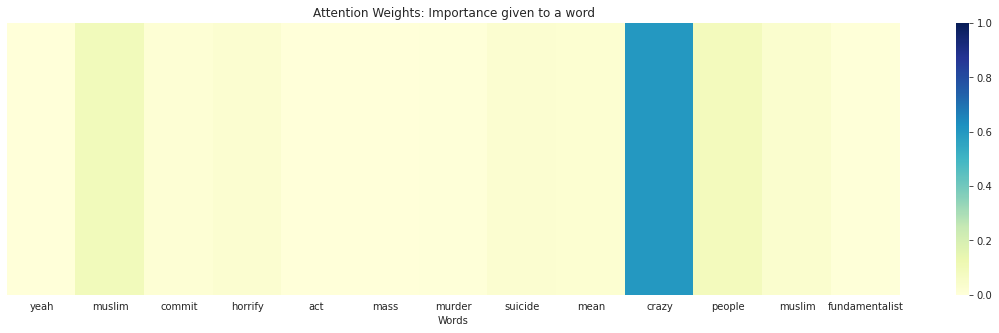

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Where was his respect for the israeli pm? Or scalia? Please dont post stupid comments 
Preprocessed: respect israeli private message scalia please not post stupid comment 
Identities:  
Actual: 1 
Prediction: 0.9948644

1/1 [==============================] - 0s 51ms/step


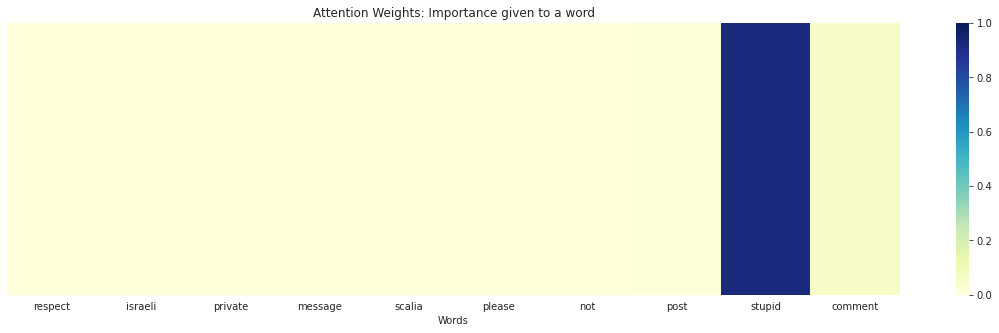

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: IF THEY WOULD HAVE THROW THE SCUM IN PRISON WHEN HE MURDERED MY PARENTS 14 YRS AGO HIS SON WOULDN'T HAVE HAD THE CHANCE TO SHOOT HIM NOW... 
Preprocessed: would throw scum prison murder parent yrs ago son would not chance shoot 
Identities:  
Actual: 1 
Prediction: 0.99002403

1/1 [==============================] - 0s 49ms/step


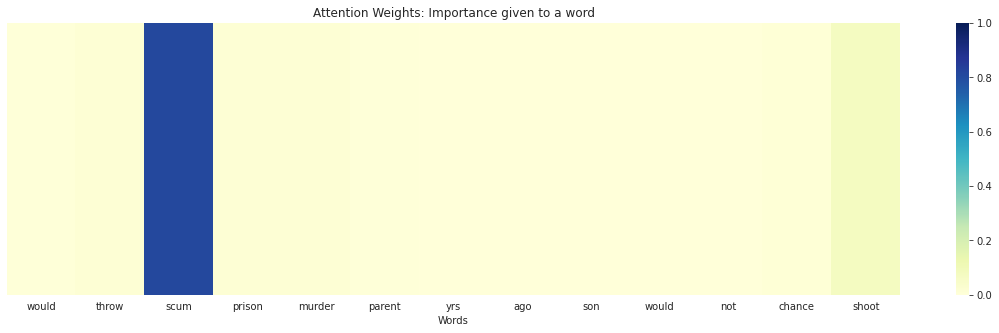

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Brown equals incompetent? 
Preprocessed: brown equal incompetent 
Identities:  
Actual: 1 
Prediction: 0.90236425

1/1 [==============================] - 0s 60ms/step


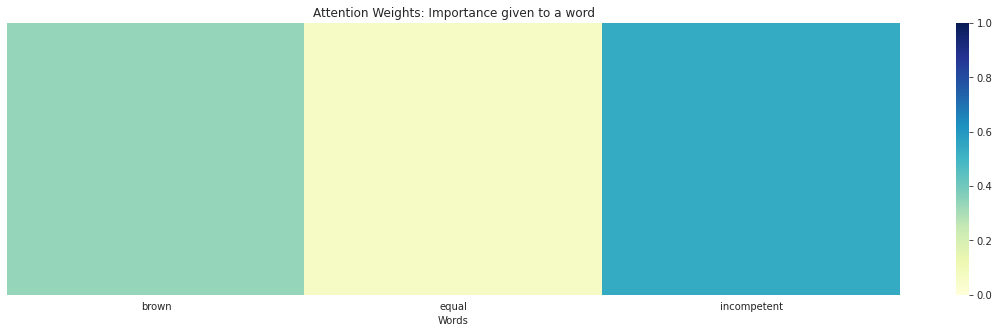

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [121]:
#checking toxic samples in the high accuracy prediction set 
tmp = train_pre[(train_pre['Error']<=0.1) & (train_pre['target']==1)].sample(5, random_state=42)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations: 
- Model is able to confidently predict on toxic comments containing demeaning words. The attention mechanism provides higher weights to demeaning words which enables the model to perform well on such examples. 

### Non-Toxic Comments

Comment: Yes, we have had this conversation before and the facts have changed little.  Well, other than the fact that your misandrist candidate no longer has anything to sell to Clinton Foundation "donors".  How are the donations to the foundation doing after 8 November 2016? 
Preprocessed: yes conversation fact change little well fact misandrist candidate no longer anything sell clinton foundation donor donation foundation november 
Identities:  
Actual: 0 
Prediction: 0.028871782

1/1 [==============================] - 0s 51ms/step


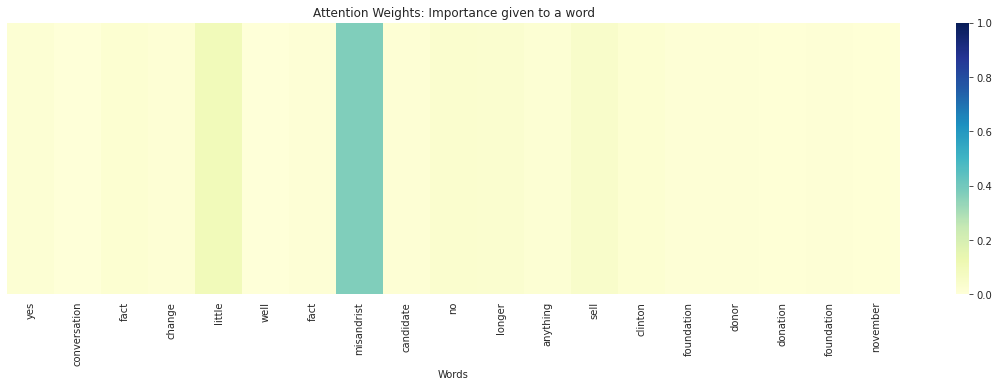

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: What ever happened to: "legal tender for all debts, public or private"  ? 
Preprocessed: ever happen legal tender debt public private 
Identities:  
Actual: 0 
Prediction: 0.0017446554

1/1 [==============================] - 0s 58ms/step


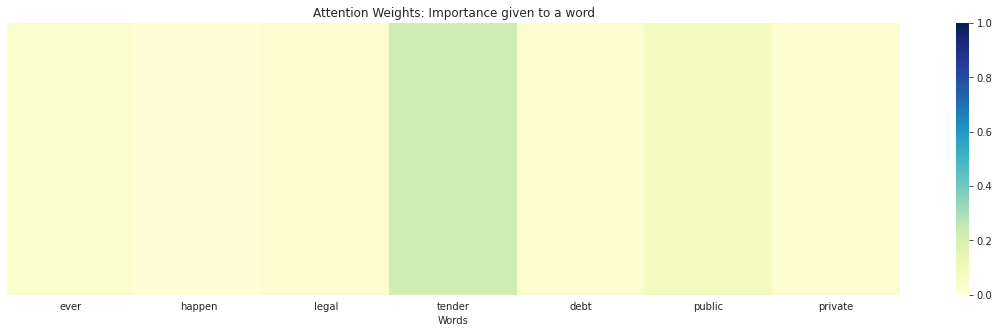

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: All men and women are made in the image and likeness of God and all are called to salvation. The source of all Truth is Christ - the Logos. 

"The desire for God is written in the human heart, because man is created by God and for God; and God never ceases to draw man to himself. Only in God will he find the truth and happiness he never stops searching for" (CCC 27).

"Those who, through no fault of their own, do not know the gospel of Christ or his Church, but who nevertheless seek God with a sincere heart, and, moved by grace, try in their actions to do his will as they know it through the dictates of their conscience—those too may achieve eternal salvation" (CCC 847). 
Preprocessed: men woman make image likeness god call salvation source truth christ logo desire god write hum

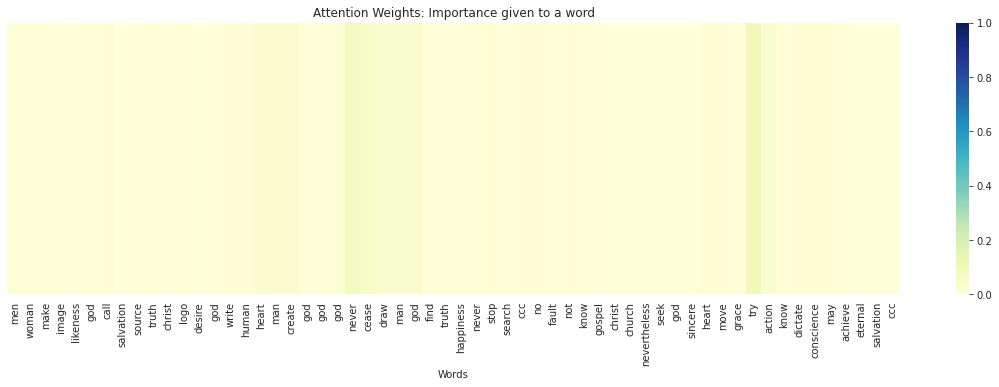

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: OMG why do we get our knickers in a twist over 50 gallons of crude?
What serious damage could this possibly do. 
Preprocessed: omg get knickers twist gallon crude serious damage could possibly 
Identities:  
Actual: 0 
Prediction: 0.091033205

1/1 [==============================] - 0s 55ms/step


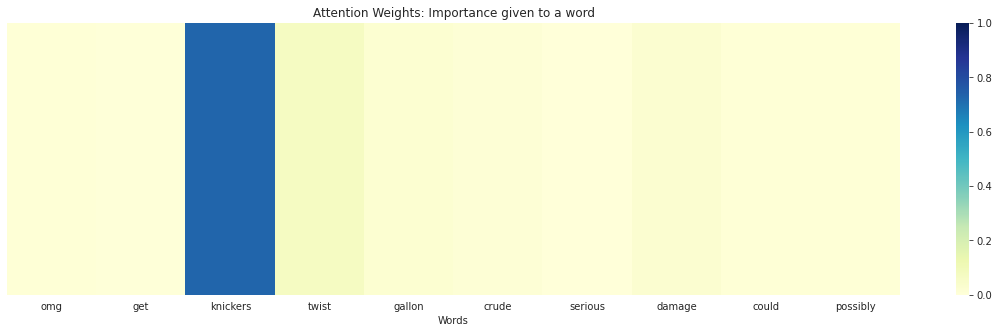

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: The cultural appropriation issue should be an embarrassment to indigenous activists , and I bet it is , to many of them.  Canada as a state has not been fair to its native citizens, sometimes intentionally and sometimes through well meaning but misguided policies. And established legal obligations to native citizens should be honored without resentment. But it makes no more sense to say that non natives can't tell native stories than to say that natives can't tell non native stories. Or that the Rolling Stones can't play the blues. Or that Eminem can't do rap. 

Eye-rolling  cultural appropriation as a concept doesn't make you racist or even insensitive. It simply means you're rational. The fact that people are loosing their jobs over this opinion is what's insane.

Oh and Canad

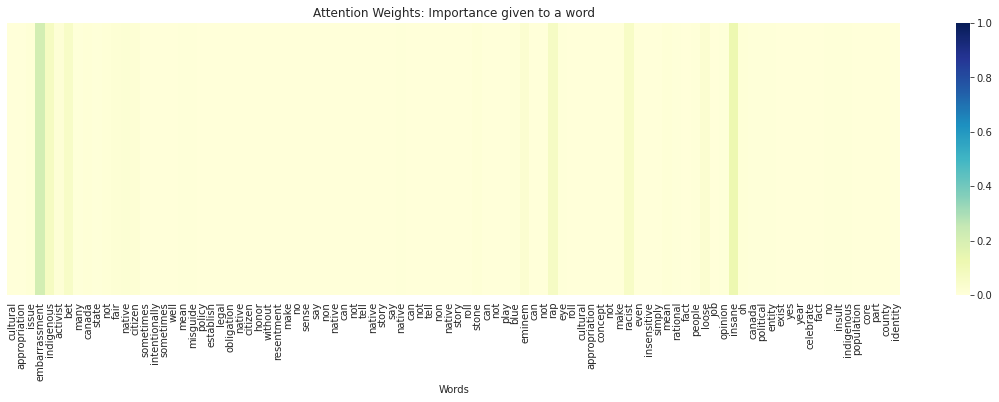

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [122]:
#checking non-toxic samples in the high accuracy prediction set 
tmp = train_pre[(train_pre['Error']<=0.1) & (train_pre['target']==0)].sample(5, random_state=42)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations: 
- Model provides nearly equal weights to all words in non-toxic comments, whenever there is a slightly demeaning word the attention mechanism provides a higher weight to that word and this affects model's confidence negatively by a slight amount like in the 4th comment.

### **2.3.1 Observing Samples where Prediction Errors are High**

### Class Distribution

In [123]:
#class distribution in samples with low accuracy predictions
train_pre[train_pre['Error']>=0.4]['target'].value_counts(normalize=True)

0    0.577301
1    0.422699
Name: target, dtype: float64

### Toxic Comments

Comment: Trump acts like a spoiled 10 year old and has the vocabulary of someone who suffered a head injury.  Our President.  Good grief. 
Preprocessed: trump act like spoiled year old vocabulary someone suffer head injury president good grief 
Identities:  
Actual: 1 
Prediction: 0.5107394

1/1 [==============================] - 0s 96ms/step


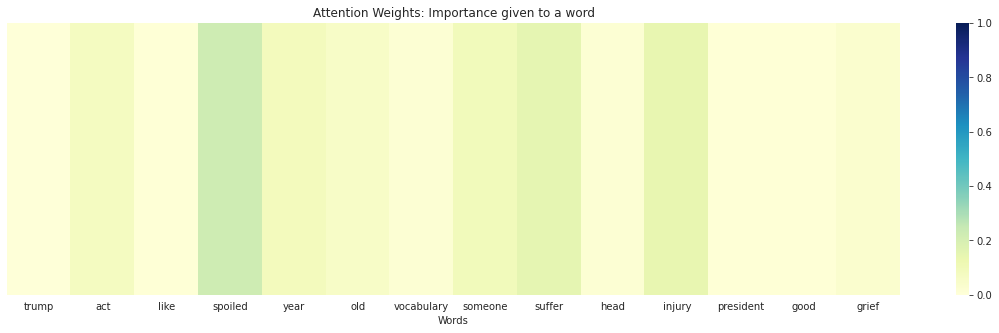

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Wrong. The bible and all it's source material is the biggest fake of all. 
Preprocessed: wrong bible source material big fake 
Identities:  
Actual: 1 
Prediction: 0.23499972

1/1 [==============================] - 0s 108ms/step


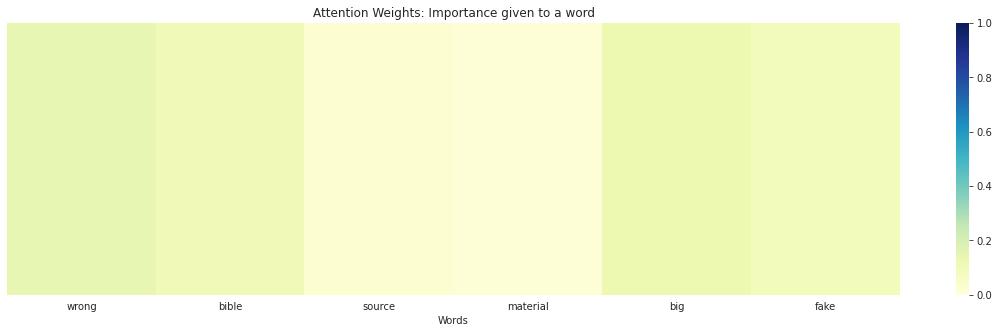

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Again, I have changed my name to reflect your sick game back at you! You need to stop this now! 
Preprocessed: change name reflect sick game back need stop 
Identities:  
Actual: 1 
Prediction: 0.5170839

1/1 [==============================] - 0s 130ms/step


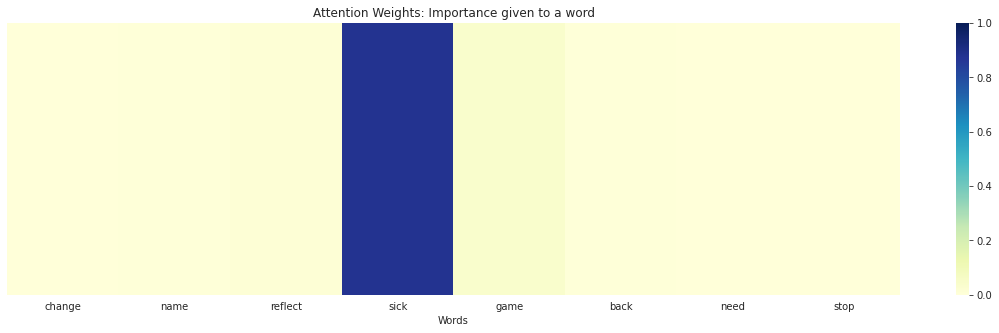

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: It cant be racists, he said white. /s 
Preprocessed: can not racists say white 
Identities: white 
Actual: 1 
Prediction: 0.2978769

1/1 [==============================] - 0s 134ms/step


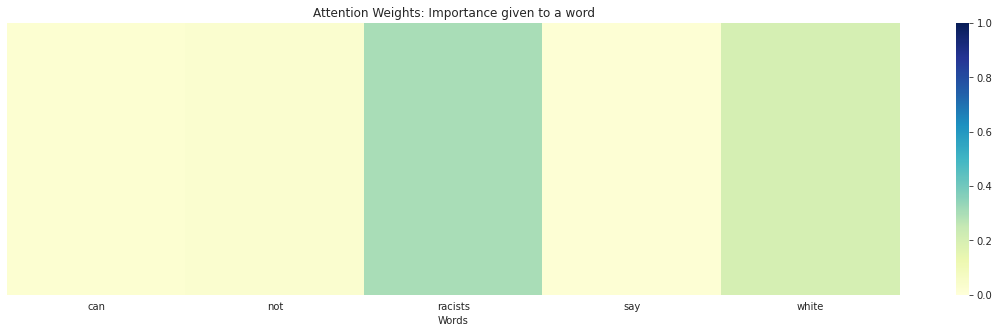

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Black block protesters funded by George Sorrows and defending his turf. 
Preprocessed: black block protester fund george sorrow defend turf 
Identities: black 
Actual: 1 
Prediction: 0.44723824

1/1 [==============================] - 0s 95ms/step


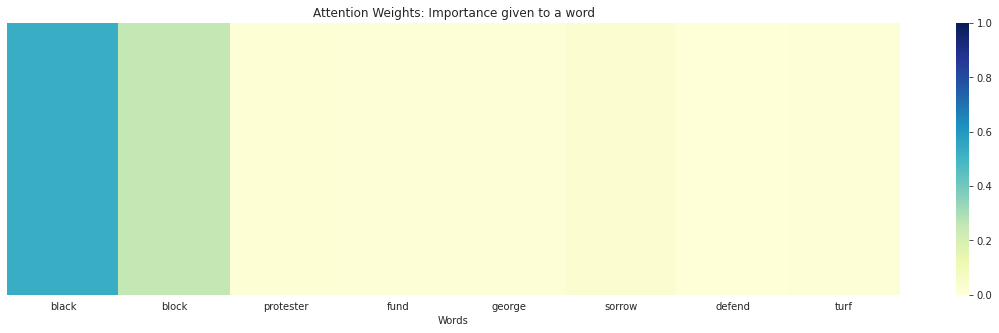

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [124]:
#checking toxic samples in the low accuracy prediction set 
tmp = train_pre[(train_pre['Error']>=0.4) & (train_pre['target']==1)].sample(5, random_state=42)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations: 
- Our model fails to confidently identify toxicity in comments written in a satirical tone like "Trump acts like a spoiled 10 year old and has the vocabulary of someone who suffered a head injury.  Our President.  Good grief."
- Model also fails to confidently idenify toxicity in comments which don't use any offensive words but their overall tone and meaning is toxic like "Again, I have changed my name to reflect your sick game back at you! You need to stop this now!"
- There are comments which are replies to another comment or have some prior context are labeled as toxic and here our model fails to identify such comments with high accuracy because the words used don't seem to be demeaning. For instance, "It cant be racists, he said white", "Black block protesters funded by George Sorrows and defending his turf." Such comments could be treated like outliers.

### Non-Toxic Comments

Comment: obvious to whom?  You?  Are there solid facts on this that I missed?  Have there been non.biased polls taken on this?  Isn't that like saying "all Mexicans crossing the boarder rapist, murderers and killers?  Si yo hablo Espanol y creo que Mexicanos es muy bueno gente.  

I can always use more practice in tolerance, patience.  Certainly I have to push myself to be kinder and more thoughtful.  Doesn't everyone?  I know my background.  I know the pain, anger and fear I carry but I tell you true: I'm aware of my shortcomings.  Are you?  W/this kind of selfish and judgmental mindset, one would hope so.

Thanks for your comment

L2g 
Preprocessed: obvious solid fact miss non bias poll take not like say mexican cross boarder rapist murderer killer si yo hablo espanol creo que mexicano es muy bueno gente always use practice tolerance patience certainly push kinder thoughtful not everyone know background know pain anger fear carry tell true aware shortcoming w kind selfish judgmental 

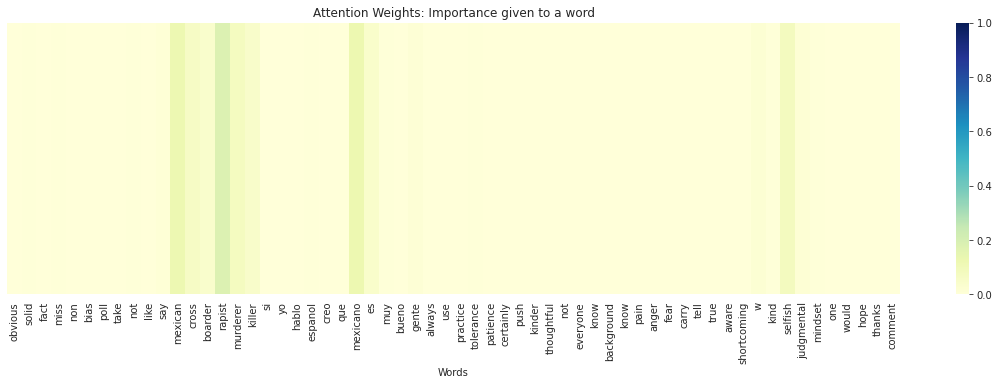

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Yer too funny, teeny-weeny, Itsme. Nobody can hold a candle to  your wasteful oil soaked clowns in the capitol.  Keep peddling with the Rs.  Haha 
Preprocessed: yer funny teeny weeny nobody hold candle wasteful oil soak clown capitol keep peddle rs haha 
Identities:  
Actual: 0 
Prediction: 0.6503911

1/1 [==============================] - 0s 56ms/step


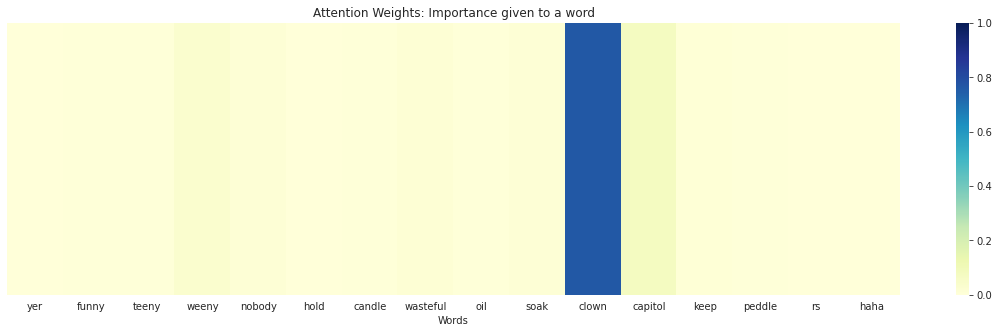

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Until you offer one scintilla of proof, your latest allegation is useless. 
Preprocessed: offer one scintilla proof late allegation useless 
Identities:  
Actual: 0 
Prediction: 0.6308362

1/1 [==============================] - 0s 50ms/step


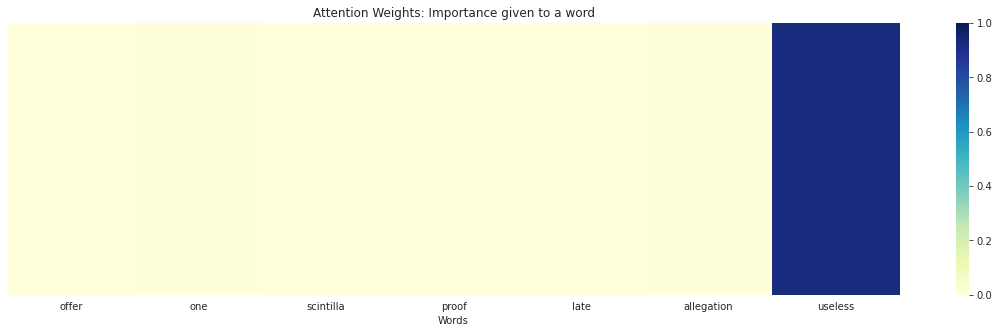

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: That's just a bunch of baloney.  Ralph Klein gave Alberta's money away to the richest 10 people just to stay elected.  He let education, hospitals and roads rot while getting publicly drunk and embarrassing himself.  Get real. 
Preprocessed: bunch baloney ralph klein give alberta money away rich people stay elect let education hospital roads rot get publicly drink embarrass get real 
Identities:  
Actual: 0 
Prediction: 0.42387977

1/1 [==============================] - 0s 51ms/step


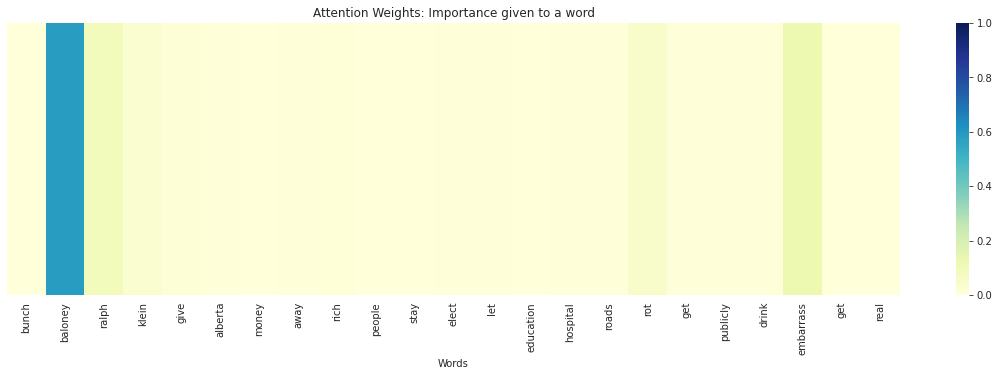

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Ooooh, this is gonna be gooood!  Let's face it, take away Trumps twitter account and you just have a boring old bigot.  But, thanks to narcissism and technology, and you have some of the best entertainment insanity can provide! 
Preprocessed: ooooh go gooood let us face take away trump twitter account bore old bigot thanks narcissism technology best entertainment insanity provide 
Identities:  
Actual: 0 
Prediction: 0.49353653

1/1 [==============================] - 0s 52ms/step


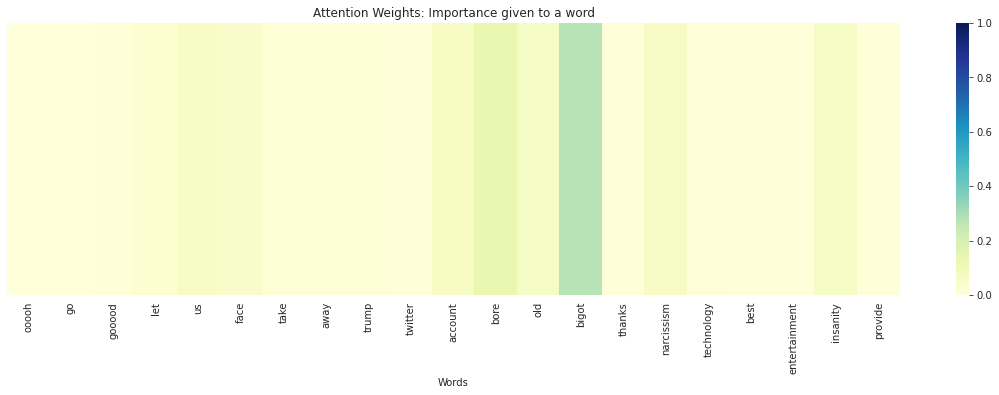

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [125]:
#checking non-toxic samples in the low accuracy prediction set 
tmp = train_pre[(train_pre['Error']>=0.4) & (train_pre['target']==0)].sample(5, random_state=42)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations: 
- Model fails to achieve accuracy on comments which voice their disagreement towards insulting steriotypical remarks made on some community by highlighting/quoting the remarks that are made like
"obvious to whom?  You?  Are there solid facts on this that I missed?  Have there been non.biased polls taken on this?  Isn't that like saying "all Mexicans crossing the boarder rapist, murderers and killers?  Si yo hablo Espanol y creo que Mexicanos es muy bueno gente.  
I can always use more practice in tolerance, patience.  Certainly I have to push myself to be kinder and more thoughtful.  Doesn't everyone?  I know my background.  I know the pain, anger and fear I carry but I tell you true: I'm aware of my shortcomings.  Are you?  W/this kind of selfish and judgmental mindset, one would hope so.
Thanks for your comment"
- There are words which are common in non-toxic and toxic comments, these are words which can be used sensibly as well as insultingly like clown, useless, baloney. It is observed that our model's accuracy decreases when such words are used in non-toxic comments.

## **2.4 Analyzing Uninteded Bias**

- The main aim of this case study is to reduce the unintended bias towards communities, so let's do an analysis if our model was able to do the needful.
We look at the samples with low/high error, identity mentioned, non-toxic comments. 
- This way we can look at exmaples where our model performs well and where it performs poorly in case of identity mentioned, non-toxic comments.

In [97]:
train_pre['has_identity'] = train_pre[identity_main].apply(lambda x: 1 if any(x) else 0, axis=1)

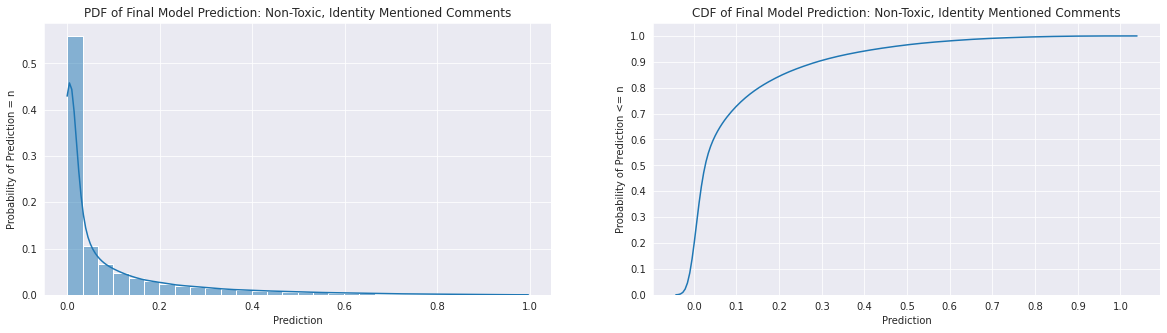

In [136]:
tmp = train_pre[(train_pre['target']==0) & (train_pre['has_identity']==1)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data=tmp, x="Model_4", bins=30, stat = 'proportion', ax=ax[0], kde=True)
ax[0].set(xlabel='Prediction', ylabel='Probability of Prediction = n', title='PDF of Final Model Prediction: Non-Toxic, Identity Mentioned Comments')
sns.kdeplot(data=tmp, x="Model_4", ax=ax[1], cumulative=True)
ax[1].set(xlabel='Prediction', ylabel='Probability of Prediction <= n', title='CDF of Final Model Prediction: Non-Toxic, Identity Mentioned Comments')
ax[1].set_xticks(np.arange(0,1.1,0.1))
ax[1].set_yticks(np.arange(0,1.1,0.1))
plt.show()

In [138]:
#total non-toxic, identity mentioned comments
tmp.shape[0]

136588

Observations: 
- ~75% point predictions in total non-toxic,identity mentioned comments are under 0.1. (Low Error)
- ~5% point predictions in total non-toxic,identity mentioned comments are more than equal to 0.4. (High Error)

### **2.4.1 Observing Non-Toxic,Identity Mentioned Comments where Prediction Errors are Low**

Comment: "House Speaker Paul Ryan said he will not support a resolution to censure President Donald Trump over his comments following a white supremacist rally in Virginia"

The word "spineless" keeps coming up whenever Ryan is mentioned. 
Preprocessed: house speaker paul ryan say not support resolution censure president donald trump comment follow white supremacist rally virginia word spineless keep come whenever ryan mention 
Identities: white 
Actual: 0 
Prediction: 0.025615694

1/1 [==============================] - 0s 61ms/step


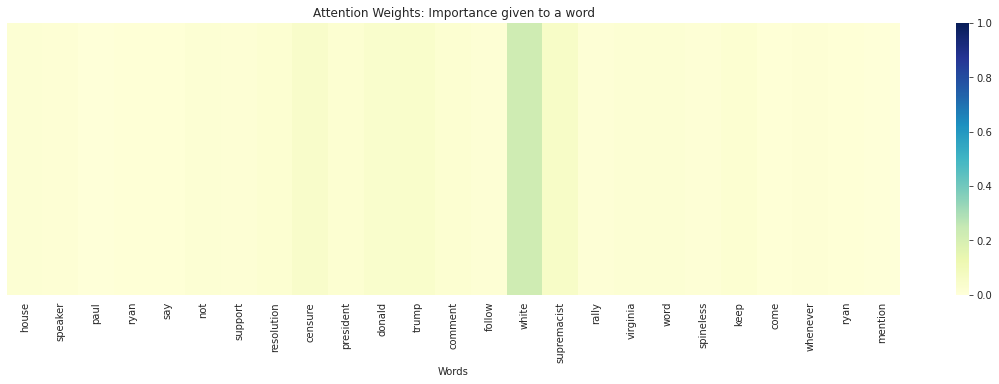

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: I can't remember the exact date, but last fall when the story of the veil was in the news in Quebec, I observed a veiled woman at a shopping mall.  She just stood outside the H&M door near the mall entrance for at least 15 minutes, holding her cell phone, but not speaking into it. I thought that perhaps she was waiting for someone, but after a period of time, she just left the mall. 

I had the impression that she was there  expecting to invoke some type of reaction and take a photo, but no one took the bait.

Sure enough, I saw her again in the parking lot, where she took off her veil, got in her car and drove away. 
Preprocessed: can not remember exact date last fall story veil news quebec observe veiled woman shop mall stand outside h door near mall entrance least minute hold

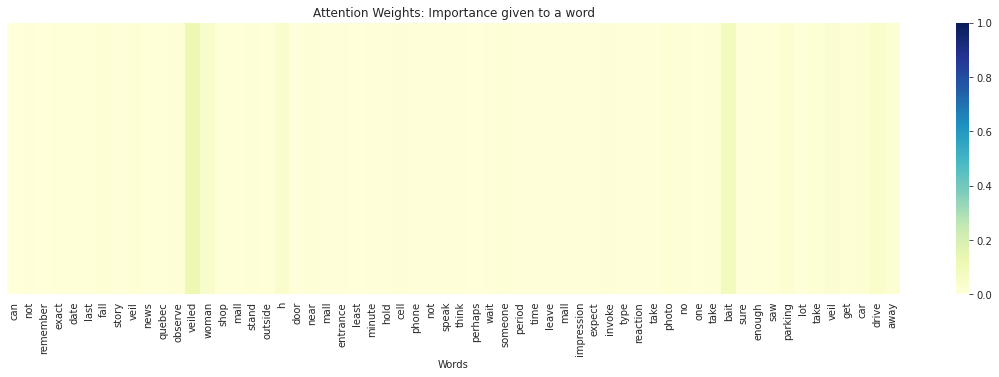

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Just an FYI - I was not advocating for private schools (vouchers); I attended our local Catholic schools (and no, we were not rich!) which did not take any money away from the public schools. I was advocating for the teachers I had and all the other teachers at private schools that do an excellent job. 
Preprocessed: information not advocate private school voucher attend local catholic school no not rich not take money away public school advocate teacher teacher private school excellent job 
Identities: christian 
Actual: 0 
Prediction: 0.00027915102

1/1 [==============================] - 0s 50ms/step


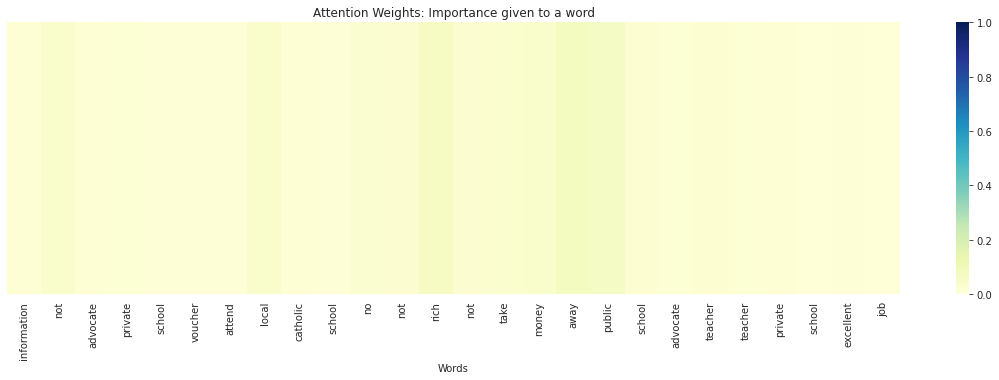

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: If that memo was not true there would be no need for feminism 
Preprocessed: memo not true would no need feminism 
Identities: female 
Actual: 0 
Prediction: 0.026316933

1/1 [==============================] - 0s 49ms/step


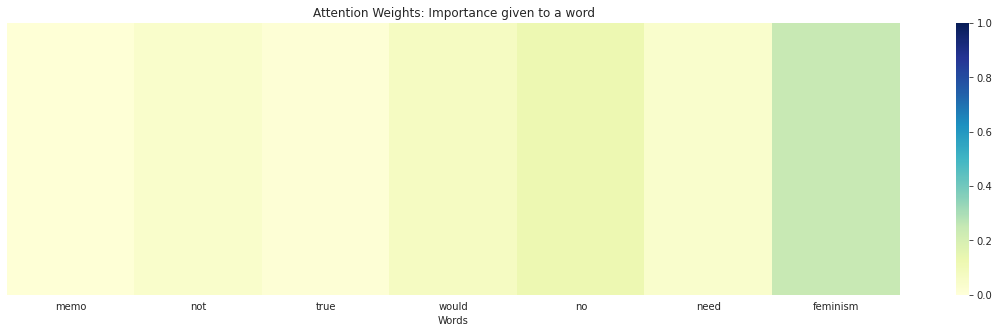

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: HV is obviously wrong, bot on sex and on life.  The current doctrine on original sin, which relies on the disobedience of some lost set of first parents rather than really looking at the Eden myth critically and seeing that the original sin is blame is ripe for correction.  The fetish that Asexuals have for proving that scripture shows that Jesus was one of them, rather than a working Rabbi with a wife is deliberate fabrication.  None of this is reform of practice.  It is all doctrine. 
Preprocessed: hv obviously wrong bot sex life current doctrine original sin relies disobedience lose set first parent rather really look eden myth critically see original sin blame ripe correction fetish asexuals prove scripture show jesus one rather work rabbi wife deliberate fabrication none re

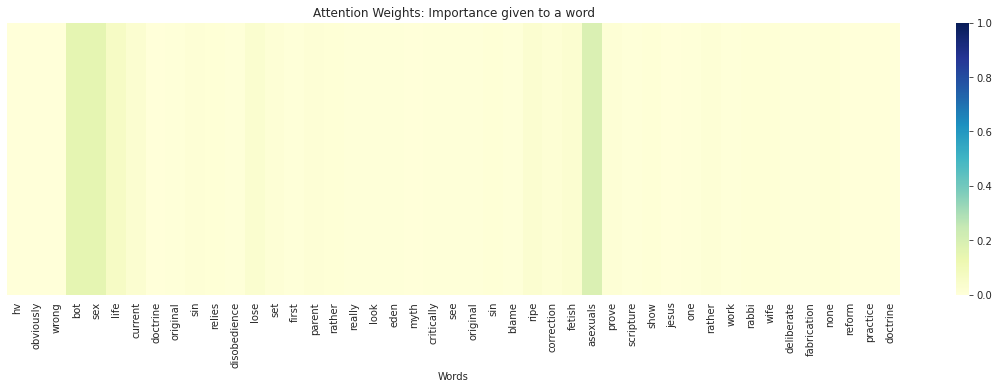

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [126]:
tmp = train_pre[(train_pre['Error']<=0.1) & (train_pre['target']==0) & (train_pre['has_identity']==1)].sample(5, random_state=42)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations:
- Model performs well when there are no demeaning words  used in the non-toxic, identity mentioned comments.
- There are non-toxic, identity mentioned comments that may use demeaning words but the context in which they are used is different but sometimes the model fails to classify correctly because of the presence of those words in the comment. We will see such examples in the next section.

### **2.4.2 Observing Non-Toxic,Identity Mentioned Comments where Prediction Errors are High**

Comment: You make a really good point.  Why is she fighting the "hate" of Canada when there is none.  Why isn't the author fighting against how these countries and Islam treat women as second class citizens, how they murder gays, how they do all sorts of nasty things to other people.  Why doesn't she stand up against that? 
Preprocessed: make really good point fight hate canada none not author fight country islam treat woman second class citizen murder gay sort nasty thing people not stand 
Identities: female, homosexual_gay_or_lesbian, muslim 
Actual: 0 
Prediction: 0.6093312

1/1 [==============================] - 0s 62ms/step


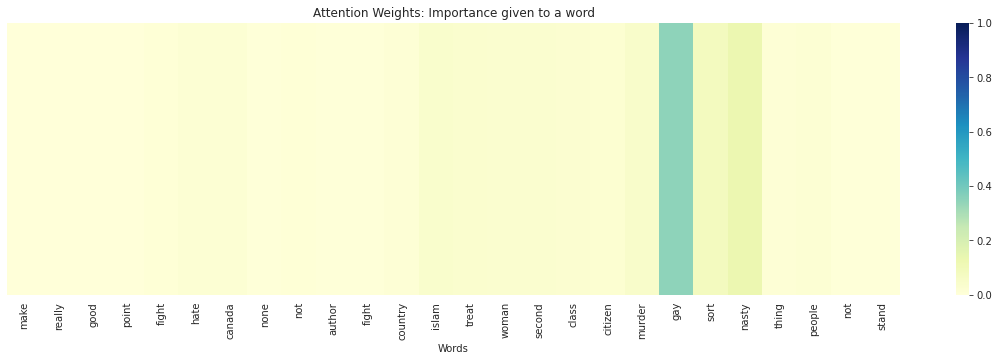

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Right, because he was black man who became president 
Preprocessed: right black man become president 
Identities: male, black 
Actual: 0 
Prediction: 0.44069454

1/1 [==============================] - 0s 124ms/step


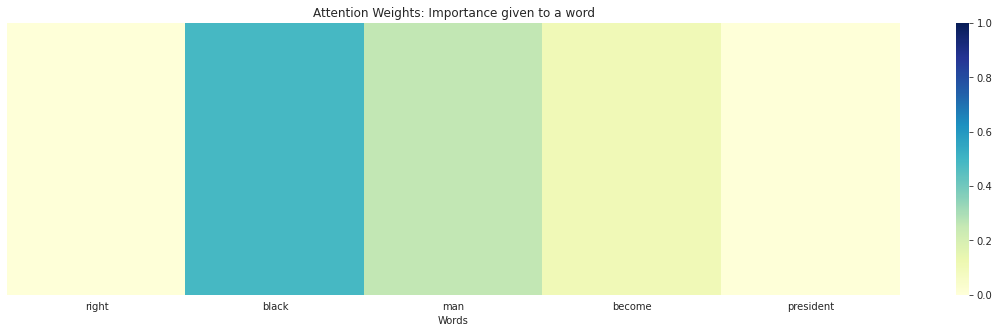

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: Oh I don't know.  Muslims are very afraid of us.  Illegals are afraid.  African Americans and mostly young children are being basically murdered all over this country.  It all started w/Trayvon.  If, as a woman, a car pulled over and two men jumped out.........started running at me aggressively..........w/o hesitation, I'd run.  Then they did it again: got out of the car and ran towards him.  I think he had every reason in the world to fear for his safety.  I'm certainly not proud of those stats at the end of the story.  Damn.  l2g 
Preprocessed: oh not know muslim afraid us illegals afraid african american mostly young child basically murder country start w trayvon woman car pull two men jump start run aggressively w hesitation would run get car ran towards think every reason w

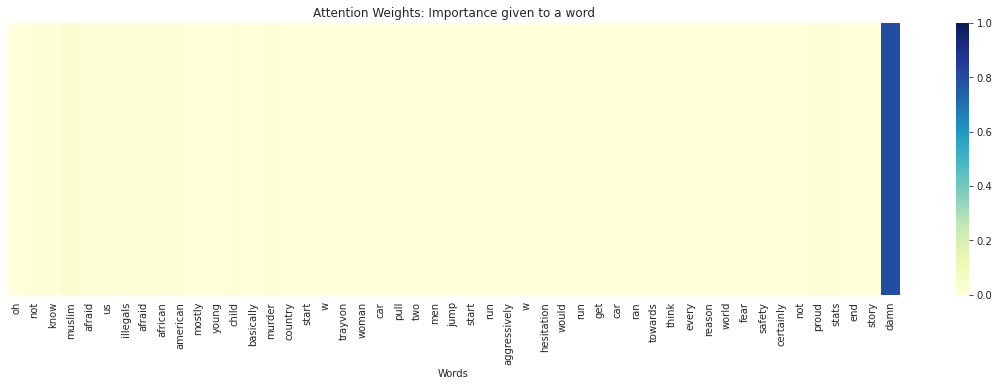

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: With all respect, Colkoch, a man or woman's sex goes to his or her very nature.  Nature itself shows this.  Civilization has known this since the inception.  Deny the significance of sex and you deny your nature itself.  Having blonde hair, or blue eyes, or a crooked nose is not remotely as differentiating as having male or female genitalia. 
Preprocessed: respect colkoch man woman sex go nature nature show civilization know since inception deny significance sex deny nature blonde hair blue eye crook nose not remotely differentiate male female genitalia 
Identities: male, female 
Actual: 0 
Prediction: 0.47071233

1/1 [==============================] - 0s 48ms/step


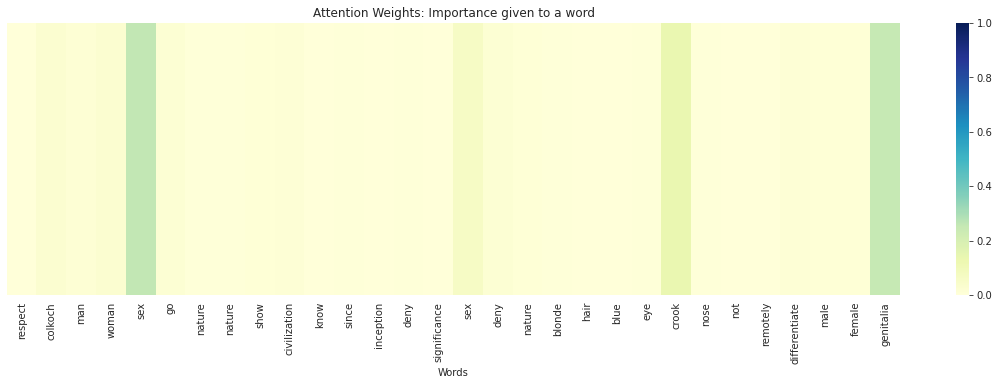

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comment: First, Trump is a low-life opportunist.  He will use the race card when he wants support from KKK, neo-Nazis, and white supremistists. He has shown that his moral fibre is very thin.  But still the Republicans do nothing about him.  Hopefully they will be swept out in the mid term elections.  Then there will be a better means of getting Trump out. 
Preprocessed: first trump low life opportunist use race card want support kkk neo nazis white supremistists show moral fibre thin still republicans nothing hopefully sweep mid term election well mean get trump 
Identities: white 
Actual: 0 
Prediction: 0.54302615

1/1 [==============================] - 0s 53ms/step


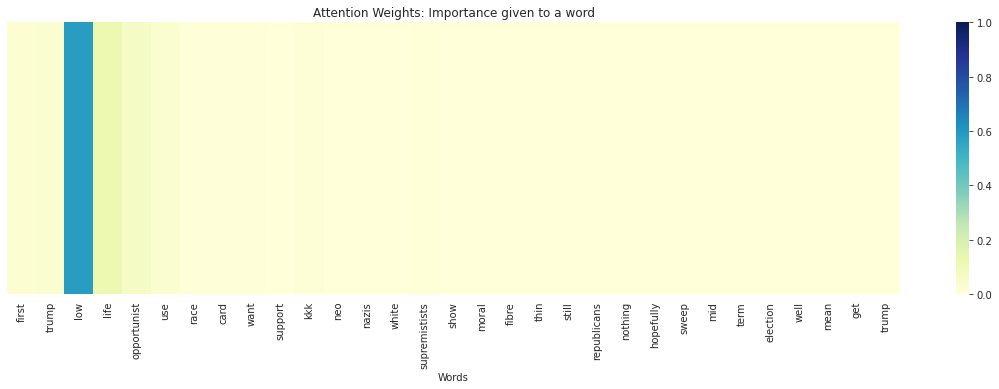

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [131]:
tmp = train_pre[(train_pre['Error']>=0.4) & (train_pre['target']==0) & (train_pre['has_identity']==1)].sample(5, random_state=48)
print_info(tmp, 'Model_4',  5, tok, padlen, att_mod)

Observations:
- Comments that voice their opinion as an ally for the communities but using toxic words in doing so are misclassified as toxic although the context in which they are used is positive. For instance, "You make a really good point.  Why is she fighting the "hate" of Canada when there is none.  Why isn't the author fighting against how these countries and Islam treat women as second class citizens, how they murder gays, how they do all sorts of nasty things to other people.  Why doesn't she stand up against that?". Words like murder,nasty, gay are given more attention here. 
- It is observed that Model gives high importance to identity words like black, ,man, gay in few comments which results in misclassification or very low confidence in predictions. This indicates that model still has unintended bias on some examples.
 

# **3. Conclusion**

- There are common words between toxic and non-toxic comments, the difference between the two lies in the usage of these words. However, the model fails to identify this difference in some cases.  
- Model performs poorly on non-toxic comments using demeaning words for the sake of supporting communities like *'obvious to whom?  You?  Are there solid facts on this that I missed?  Have there been non.biased polls taken on this?  Isn't that like saying "all Mexicans crossing the boarder rapist, murderers and killers?"'.* Here a few demeaning words are used but for the sake of proving a point in support of the Mexicans.
- Model also performs poorly on toxic comments which may not use demeaning words but make statements that can hurt sentiments of people like *"Wrong. The bible and all it's source material is the biggest fake of all."*. 
Or toxic comments that are written in a satirical tone like *"Trump acts like a spoiled 10 year old and has the vocabulary of someone who suffered a head injury.  Our President.  Good grief."*
- Model performs the best on toxic comments which make use of demeaning words and non-toxic comments which don't make use of any demeaning words, this might be because the train data includes more of these kinds of comments.